In [1]:
from SOH_func import *
import matplotlib.pyplot as pl
from tensorflow import summary as sm
from tensorflow import keras
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import datetime
import os

%load_ext tensorboard

In [2]:
VERSION = 'MoreData'

FILE_00 = 'data_csv/CYCLE_CSV_data.csv'
FILE_01 = 'data_csv/CYCLE_CSV_data01.csv'
FILE_02 = 'data_csv/CYCLE_CSV_data02.csv'
FILE_03 = 'data_csv/CYCLE_CSV_data03.csv'
FILE_04 = 'data_csv/CYCLE_CSV_data04.csv'
FILE_05 = 'data_csv/CYCLE_CSV_data05.csv'
FILE_06 = 'data_csv/CYCLE_CSV_data06.csv'
FILE_07 = 'data_csv/CYCLE_CSV_data07.csv'

In [3]:
drop_labels_x = ['인덱스', '사이클_번호', '누적_용량(Ah)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']
drop_labels_y = ['인덱스', '사이클_번호', '충전_용량(Ah)', '누적_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)', '누적_에너지(Wh)', '쿨롱_효율(%)', '에너지_효율(%)', '최대_전압(V)', '충전_최종전압(V)', '방전_최종전압(V)', '단위_충전_용량(Ah/g)', '방전_최종전압(V)', '단위_방전_용량(Ah/g)']

param = {'seq_len' : 20, 'num_units' : 32, 'num_filters' : 128, 'window' : 3, 'dropout': 0.2, 'num_epochs' : 5000, 'num_dense': 16}

log_dir = f"logs/{VERSION}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M") + f'-{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
file_path = f'Checkpoints\{VERSION}\SOH_Checkpoint\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ\{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.h5'
hist_freq = 250

save_path = f'outputs\{VERSION}\{param["num_filters"]}FL-{param["num_units"]}UN-{param["num_epochs"]}EP-{param["seq_len"]}SQ'
try:
    if not os.path.exists(save_path):
        os.makedirs(save_path)
except OSError:
    print('Error Creating Directory...')

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data.csv => (475, 4)


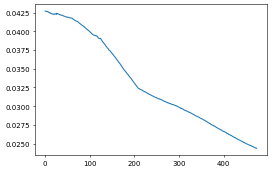

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data02.csv => (515, 4)


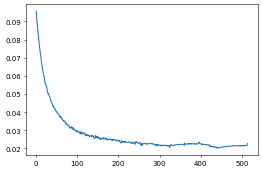

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data04.csv => (515, 4)


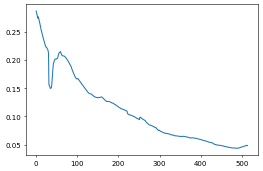

Index(['충전_용량(Ah)', '방전_용량(Ah)', '충전_에너지(Wh)', '방전_에너지(Wh)'], dtype='object')
Index(['방전_용량(Ah)'], dtype='object')
data_csv/CYCLE_CSV_data01.csv => (515, 4)


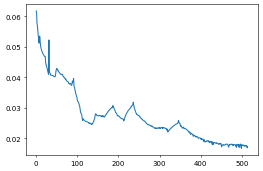

In [4]:
data00, data_cap00 = get_data(FILE_00, drop_labels_x, drop_labels_y)
data01, data_cap01 = get_data(FILE_01, drop_labels_x, drop_labels_y)
data_test, data_cap_test = get_data(FILE_02, drop_labels_x, drop_labels_y)

In [5]:
x_train00 = seq_gen_x(data00, param['seq_len'])
y_train00 = seq_gen_y(data_cap00, param['seq_len'])
x_train01 = seq_gen_x(data01, param['seq_len'])
y_train01 = seq_gen_y(data_cap01, param['seq_len'])
x_test = seq_gen_x(data_test, param['seq_len'])
y_test = seq_gen_y(data_cap_test, param['seq_len'])
print(x_train00.shape)
print(y_train00.shape)
print(x_train00[0, 0:6, 0])
print(y_train00[0, :6])

(22, 20, 4)
(22, 20, 1)
[0.0438543  0.04381967 0.04381165 0.04377159 0.04378083 0.04376632]
[[0.04269575]
 [0.04269023]
 [0.0426544 ]
 [0.0426717 ]
 [0.04264919]
 [0.04261333]]


In [6]:
model = models.Sequential()
model.add(layers.Conv1D(param['num_filters'], param['window'], padding='causal', input_shape = (None, x_train00.shape[-1])))
model.add(layers.LSTM(param['num_units'], return_sequences = True))
model.add(layers.TimeDistributed(layers.Dense(param['num_dense'])))
model.add(layers.TimeDistributed(layers.Dense(1)))
model.compile(loss = 'mse', optimizer = 'Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 128)         1664      
                                                                 
 lstm (LSTM)                 (None, None, 32)          20608     
                                                                 
 time_distributed (TimeDistr  (None, None, 16)         528       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1)          17        
 tributed)                                                       
                                                                 
Total params: 22,817
Trainable params: 22,817
Non-trainable params: 0
_________________________________________________________________


In [7]:
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train00, y_train00, epochs=param['num_epochs'], verbose = 3, validation_split = 0.3, callbacks=callback_list)
callback_list = [ModelCheckpoint(filepath = file_path, monitor = 'val_loss', save_best_only = True),
                 TensorBoard(log_dir=log_dir, histogram_freq=hist_freq)]
fitdata = model.fit(x_train01, y_train01, epochs=param['num_epochs'], verbose = 3, validation_split = 0.3, callbacks=callback_list)

Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000
Epoch 70/5000
Epoch 71/5000
Epoch 72/5000
E

1/1 [==============================] - 0s 215ms/step
(480, 1)
outputs\MoreData\128FL-32UN-5000EP-20SQ


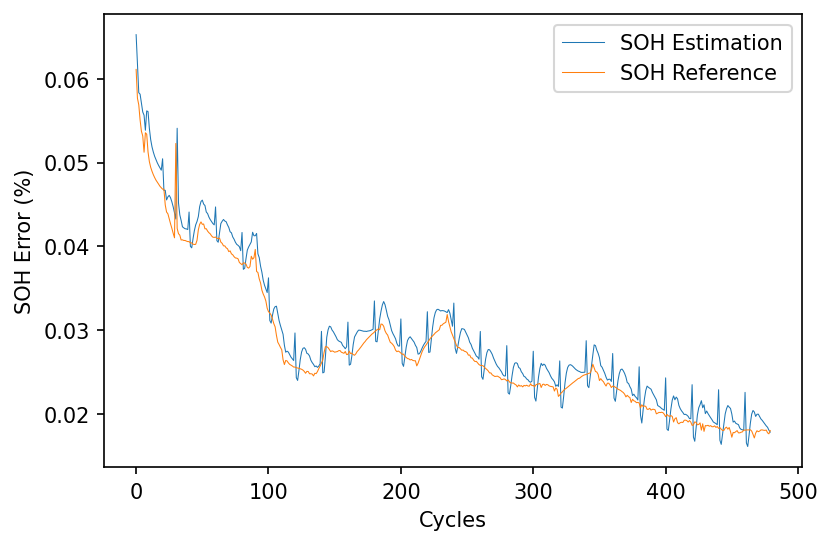

In [8]:
RMSE, MAE, Error_rate = show_and_prove(model, file_path, x_test, y_test, save_path, return_loss=True)

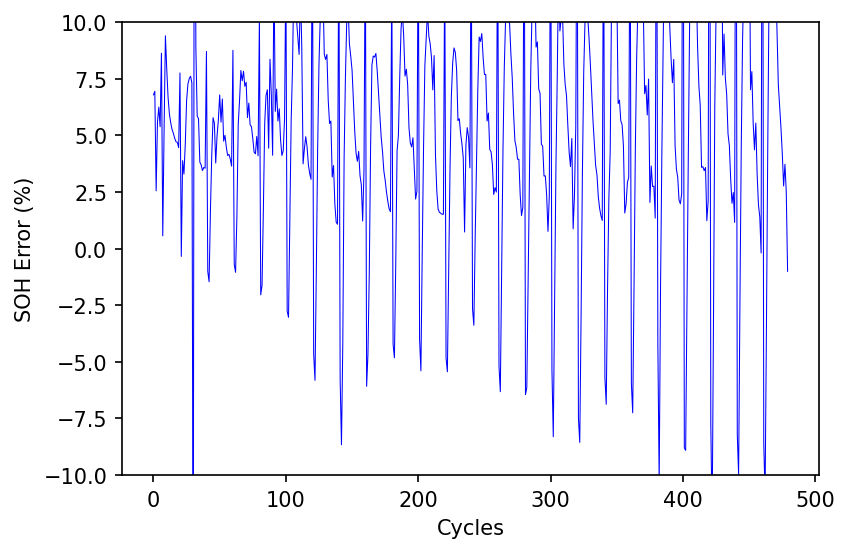

RMSE(0.078147), MAE(0.065611)


In [9]:
pl.figure(dpi=150)
line = pl.plot(Error_rate)
pl.ylim(-10, 10)
pl.ylabel('SOH Error (%)')
pl.xlabel('Cycles')
pl.setp(line, color='b', linewidth=0.5)
pl.savefig(f'{save_path}\\ErrRate-RMSE({RMSE:.4f})MAE({MAE:.4f}).png')
pl.show()
print(f'RMSE({RMSE:.6f}), MAE({MAE:.6f})')